Math 5750/6880: Mathematics of Data Science \
Project 3

# 1. Fashion-MNIST image classification using sklearn

In [2]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(len(X_train), -1)
X_test  = X_test.reshape(len(X_test), -1)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64), #Number of hidden layers and neurons
    activation='relu', #Activation functions
    solver='adam', #Optimization method and the learning rate
    alpha=0.001, #Regularization
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, #Early stopping
    max_iter=50, #To pevent it from taking forever
    random_state=1)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)
confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_matrix)



Accuracy: 0.8853
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.81      0.80      1000
           3       0.90      0.88      0.89      1000
           4       0.80      0.83      0.82      1000
           5       0.97      0.97      0.97      1000
           6       0.71      0.67      0.69      1000
           7       0.94      0.97      0.96      1000
           8       0.97      0.96      0.97      1000
           9       0.97      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
[[842   2  22  19   5   1 103   0   6   0]
 [  3 971   2  18   3   0   2   0   1   0]
 [ 15   2 810  10  86   1  74   0   2   0]
 [ 25   5   9 884  49   0  24   0   4   0]
 [  0   0  

# 3. Fashion-MNIST image classification  using pytorch

In [1]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load Fashion-MNIST
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# scale to [0,1], add channel dimension -> (N, 1, 28, 28)
X_train = (X_train.astype("float32") / 255.0)[:, None, :, :]
X_test  = (X_test.astype("float32")  / 255.0)[:,  None, :, :]

y_train = y_train.astype(np.int64)
y_test  = y_test.astype(np.int64)

# train/val split: last 10k of train as validation
X_tr, X_val = X_train[:50000], X_train[50000:]
y_tr, y_val = y_train[:50000], y_train[50000:]

# wrap in PyTorch TensorDatasets and DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_tr),  torch.from_numpy(y_tr))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Using device: cuda


Epoch 1/10: 100%|██████████| 391/391 [00:03<00:00, 117.58it/s]


Epoch 1: Train loss=0.4879, acc=0.8266 | Val loss=0.3396, acc=0.8738


Epoch 2/10: 100%|██████████| 391/391 [00:03<00:00, 114.48it/s]


Epoch 2: Train loss=0.3026, acc=0.8892 | Val loss=0.2652, acc=0.9012


Epoch 3/10: 100%|██████████| 391/391 [00:03<00:00, 119.40it/s]


Epoch 3: Train loss=0.2567, acc=0.9064 | Val loss=0.2424, acc=0.9106


Epoch 4/10: 100%|██████████| 391/391 [00:03<00:00, 119.32it/s]


Epoch 4: Train loss=0.2249, acc=0.9175 | Val loss=0.2323, acc=0.9114


Epoch 5/10: 100%|██████████| 391/391 [00:03<00:00, 114.25it/s]


Epoch 5: Train loss=0.1982, acc=0.9261 | Val loss=0.2238, acc=0.9175


Epoch 6/10: 100%|██████████| 391/391 [00:03<00:00, 118.87it/s]


Epoch 6: Train loss=0.1774, acc=0.9347 | Val loss=0.2095, acc=0.9220


Epoch 7/10: 100%|██████████| 391/391 [00:03<00:00, 118.97it/s]


Epoch 7: Train loss=0.1562, acc=0.9415 | Val loss=0.2178, acc=0.9219


Epoch 8/10: 100%|██████████| 391/391 [00:03<00:00, 116.04it/s]


Epoch 8: Train loss=0.1414, acc=0.9459 | Val loss=0.2221, acc=0.9214


Epoch 9/10: 100%|██████████| 391/391 [00:03<00:00, 116.45it/s]


Epoch 9: Train loss=0.1268, acc=0.9520 | Val loss=0.2163, acc=0.9252


Epoch 10/10: 100%|██████████| 391/391 [00:03<00:00, 118.37it/s]


Epoch 10: Train loss=0.1108, acc=0.9593 | Val loss=0.2276, acc=0.9234

Test loss: 0.2520, accuracy: 0.9206


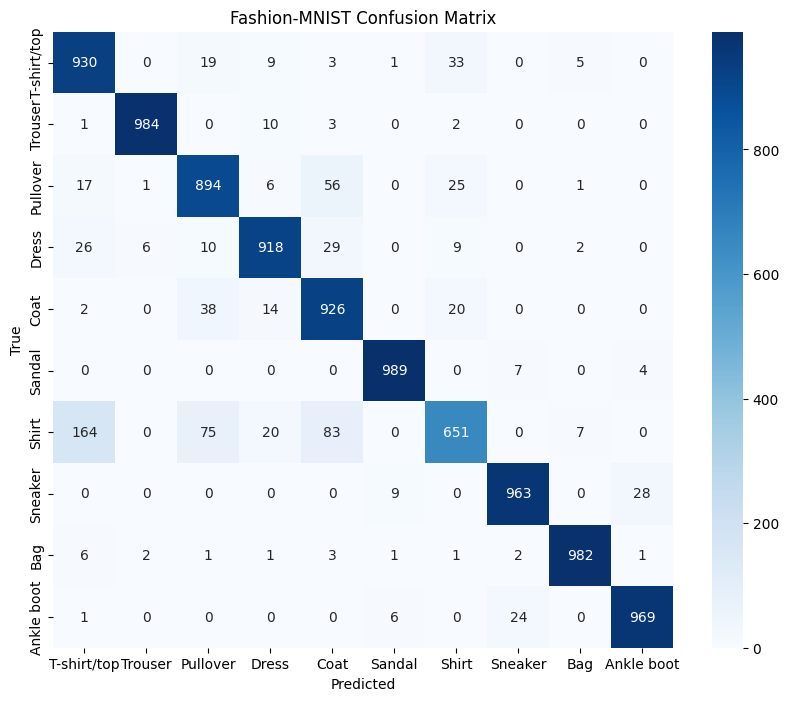


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.93      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.86      0.89      0.88      1000
       Dress       0.94      0.92      0.93      1000
        Coat       0.84      0.93      0.88      1000
      Sandal       0.98      0.99      0.99      1000
       Shirt       0.88      0.65      0.75      1000
     Sneaker       0.97      0.96      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm  # for progress bars

# In colab, you should ``change runtime type'' to GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
model = FashionCNN().to(device)

# --- Loss and optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# --- Training loop ---
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item() * X.size(0)
                val_correct += (outputs.argmax(1) == y).sum().item()
                val_total += y.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}: "
              f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"Val loss={val_loss:.4f}, acc={val_acc:.4f}")

# --- Run training ---
train_model(model, train_loader, val_loader, epochs=10)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Evaluate on test set ---
def evaluate_model(model, test_loader):
    model.eval()
    test_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            test_loss += loss.item() * X.size(0)
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= total
    test_acc = correct / total
    print(f"\nTest loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
    return np.array(all_labels), np.array(all_preds)

# --- Run test evaluation ---
labels, preds = evaluate_model(model, test_loader)

# --- Confusion matrix ---
cm = confusion_matrix(labels, preds)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Fashion-MNIST Confusion Matrix")
plt.show()

# --- Classification report ---
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))